In [1]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
# 1. 라이브러리 불러오기
import pandas as pd  # 데이터프레임 다루기
import time  # 실행 시간 측정용
from sklearn.model_selection import train_test_split, RandomizedSearchCV  # 데이터 분할과 랜덤 탐색용
from sklearn.ensemble import RandomForestClassifier  # 랜덤 포레스트 모델
from sklearn.preprocessing import StandardScaler  # 정규화(표준화) 도구
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score  # 평가 지표 함수
from imblearn.over_sampling import SMOTE  # 클래스 불균형 해결용 오버샘플링

# 2. 실행 시간 측정 시작
start_time = time.time()  # 전체 코드 실행 시간 측정 시작

# 3. 데이터 불러오기
df = pd.read_excel("filtered_data_with_date_sp500.xlsx")  # 엑셀에서 데이터 불러오기
df["Date"] = pd.to_datetime(df["Date"], origin="1899-12-30", unit="D")  # 날짜 포맷 변환

# 4. 타깃 변수 만들기: 다음날 수익률이 0.2% 초과하면 상승(1), 아니면 하락 또는 보합(0)
df["Return"] = df["S&P500"].pct_change().shift(-1)  # 다음날 수익률
df["Target"] = (df["Return"] >= 0.002).astype(int)  # 상승 여부
df = df[:-1]  # 마지막 행 제거 (미래 수익률 없음)

# 5. 기존 경제 지표 변화율 피처 생성
df["Inflation_change"] = df["InflationExpectation10Y"].pct_change()
df["Retail_change"] = df["RetailSales"].pct_change()
df["WTI_change"] = df["WTI_Oil"].pct_change()
df["PCE_change"] = df["PCE"].pct_change()
df["Gold_change"] = df["Gold"].pct_change()
df["CPI_change"] = df["CPI"].pct_change()
df["Unemp_change"] = df["UnemploymentRate"].pct_change()

# 6. 기존 기술적 분석 파생 변수 생성
df["MA10"] = df["S&P500"].rolling(window=10).mean()  # 10일 이동평균
df["Above_MA10"] = (df["S&P500"] > df["MA10"]).astype(int)  # 이동평균 위 여부
df["Return_3d_avg"] = df["Return"].rolling(window=3).mean()  # 3일 평균 수익률
df["Volatility_5d"] = df["Return"].rolling(5).std()  # 5일 변동성
df["Momentum_5d"] = df["Return"].rolling(5).sum()  # 5일 누적 수익률
df["Retail_change_lag1"] = df["Retail_change"].shift(1)  # 리테일 변화율의 1일 지연 값

# 7. 새로운 파생 변수 생성 (중복 제외)
df["CumulativeReturn_3d"] = df["Return"].rolling(3).sum()  # 3일 누적 수익률
df["Return_change_1d"] = df["Return"].diff()  # 수익률 변화량 (변동 방향)
df["Volatility_change"] = df["Volatility_5d"].diff()  # 변동성 변화량
df["SP_Gold_interaction"] = df["S&P500"].pct_change() * df["Gold_change"]  # 주가와 금 변화율 곱
df["MACD"] = df["S&P500"].ewm(span=12).mean() - df["S&P500"].ewm(span=26).mean()  # MACD 기술 지표
df["Unemp_change_lag1"] = df["Unemp_change"].shift(1)  # 실업률 변화율의 1일 지연 값
df["Gold_up_while_SP_down"] = ((df["Gold_change"] > 0) & (df["S&P500"].pct_change() < 0)).astype(int)  # 금 상승 + 주가 하락

# 8. 결측치 제거
df = df.dropna().reset_index(drop=True)  # NaN 행 제거 후 인덱스 재설정

# 9. 피처 리스트 정의
feature_cols = [
    "Inflation_change", "Retail_change", "WTI_change", "PCE_change", "Gold_change",
    "CPI_change", "Unemp_change", "Above_MA10", "Return_3d_avg", "Volatility_5d",
    "Momentum_5d", "Retail_change_lag1", "CumulativeReturn_3d", "Return_change_1d",
    "Volatility_change", "SP_Gold_interaction", "MACD", "Unemp_change_lag1",
    "Gold_up_while_SP_down"
]

# 10. 입력(X), 타깃(y) 설정
X_raw = df[feature_cols]
y = df["Target"]

# 11. 학습/테스트 분리 (시계열 유지 위해 셔플 X)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_raw, y, test_size=0.2, shuffle=False
)

# 12. 정규화 (표준화: 평균 0, 표준편차 1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)  # 학습 데이터 기준으로 스케일링
X_test_scaled = scaler.transform(X_test_raw)  # 동일 기준으로 테스트 데이터 스케일링

# 13. SMOTE 오버샘플링 적용 (클래스 불균형 해결)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# 14. 하이퍼파라미터 탐색 범위 설정 (랜덤 탐색용)
param_dist = {
    "n_estimators": [500, 1000, 2000],  # 트리 개수
    "max_depth": [10, 20, 30, None],  # 트리 최대 깊이
    "min_samples_split": [2, 4, 8],  # 내부 노드 최소 샘플 수
    "min_samples_leaf": [1, 3, 5],  # 리프 노드 최소 샘플 수
    "max_features": ['sqrt', 'log2', None]  # 각 노드에서 사용할 피처 수
}

# 15. 랜덤 탐색 수행 (모델 최적화)
random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42, class_weight='balanced'),
    param_distributions=param_dist,
    n_iter=30,
    scoring='f1',  # F1 Score 기준
    cv=3,
    n_jobs=1,
    random_state=42
)
random_search.fit(X_train_resampled, y_train_resampled)  # 최적 모델 학습

# 16. 테스트 데이터 예측
best_model = random_search.best_estimator_  # 최적 모델 추출
y_pred = best_model.predict(X_test_scaled)  # 테스트 데이터 예측

# 17. 성능 평가 (정확도, 정밀도, 재현율, F1 Score)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)

# 18. 실행 시간 계산
end_time = time.time()
elapsed_time = end_time - start_time
elapsed_str = f"{int(elapsed_time // 60)}분 {int(elapsed_time % 60)}초"

# 19. 결과 출력 (최적 하이퍼파라미터 + 성능 지표)
df_result = pd.DataFrame([{
    "hp_n_estimators": best_model.n_estimators,
    "hp_max_depth": best_model.max_depth,
    "hp_min_samples_split": best_model.min_samples_split,
    "hp_min_samples_leaf": best_model.min_samples_leaf,
    "hp_max_features": best_model.max_features,
    "Accuracy": round(accuracy, 4),
    "Precision": round(precision, 4),
    "Recall": round(recall, 4),
    "F1 Score": round(f1, 4),
    "Training Time": elapsed_str
}])

print("\n📊 최적 하이퍼파라미터 결과 및 성능 지표:")
print(df_result)

C:\Users\user\AppData\Local\Temp\ipykernel_8812\2044060211.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df["Inflation_change"] = df["InflationExpectation10Y"].pct_change()



📊 최적 하이퍼파라미터 결과 및 성능 지표:
   hp_n_estimators  hp_max_depth  hp_min_samples_split  hp_min_samples_leaf  \
0             2000            20                     2                    1   

  hp_max_features  Accuracy  Precision  Recall  F1 Score Training Time  
0            None    0.8753     0.8787  0.8642    0.8714       13분 58초  


In [3]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import platform

# ✅ 운영체제에 따라 폰트 설정
if platform.system() == 'Windows':
    plt.rc('font', family='Malgun Gothic')  # 윈도우는 '맑은 고딕'
elif platform.system() == 'Darwin':
    plt.rc('font', family='AppleGothic')  # 맥은 'AppleGothic'
else:
    plt.rc('font', family='NanumGothic')  # 리눅스 등은 나눔고딕 가정

# ✅ 마이너스 부호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

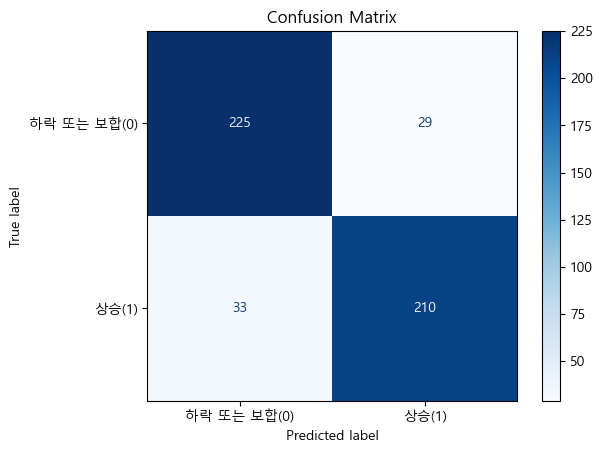

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# 혼동 행렬 시각화
disp = ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=["하락 또는 보합(0)", "상승(1)"],
    cmap=plt.cm.Blues
)
plt.title("Confusion Matrix")
plt.show()

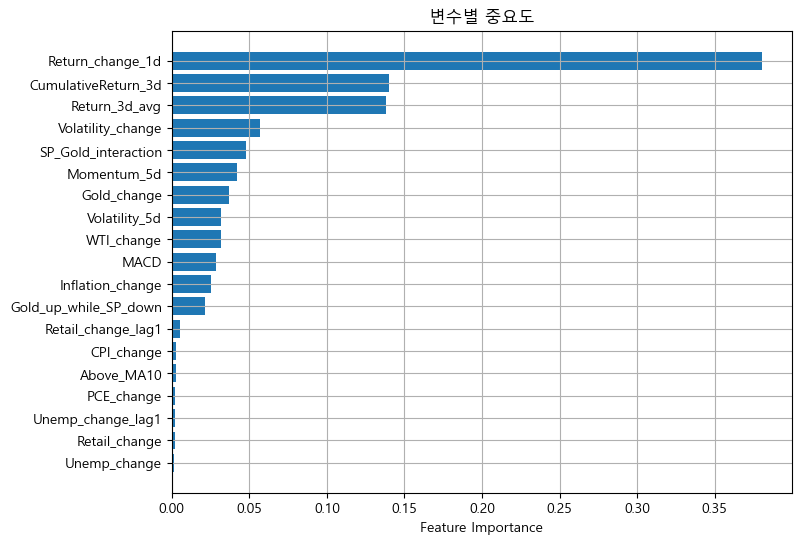

In [5]:
# 특성 중요도 추출
importances = best_model.feature_importances_
feature_names = X_raw.columns
sorted_idx = importances.argsort()[::-1]  # 중요도 기준 내림차순 정렬

# 시각화
plt.figure(figsize=(8, 6))
plt.barh(range(len(importances)), importances[sorted_idx], align='center')
plt.yticks(range(len(importances)), feature_names[sorted_idx])
plt.xlabel("Feature Importance")
plt.title("변수별 중요도")
plt.gca().invert_yaxis()  # 중요도 높은 순으로 위에 오게
plt.grid(True)
plt.show()


📈 최근 30일 전략 수익률: 18.72%
💰 100만 원 기준 수익: 187177원


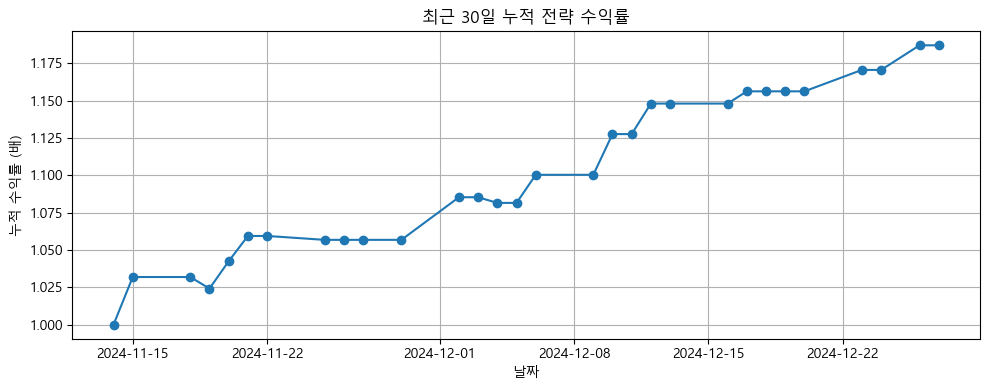

In [6]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import numpy as np

# 한글 폰트 설정 (그래프에서 한글 깨짐 방지)
plt.rcParams['font.family'] = 'Malgun Gothic'  # 윈도우용 (Mac이면 AppleGothic)

# 최근 30일 테스트셋 인덱스만 사용
recent_idx = X_test_raw.index[-30:]
recent_returns = df.loc[recent_idx, "Return"].values  # 실제 수익률
recent_dates = df.loc[recent_idx, "Date"].values
recent_preds = best_model.predict(X_test_scaled[-30:])  # 최근 30일 예측값

# 전략 수익률: 상승으로 예측한 날만 실제 수익률 반영
strategy_returns = recent_preds * recent_returns
cumulative_returns = (1 + strategy_returns).cumprod()

# 누적 수익률 계산
final_rate = cumulative_returns[-1] - 1
initial_money = 1_000_000
final_money = initial_money * (1 + final_rate)

# 결과 출력
print(f"📈 최근 30일 전략 수익률: {final_rate:.2%}")
print(f"💰 100만 원 기준 수익: {final_money - initial_money:.0f}원")

# 시각화
plt.figure(figsize=(10, 4))
plt.plot(recent_dates, cumulative_returns, marker='o')
plt.title("최근 30일 누적 전략 수익률")
plt.ylabel("누적 수익률 (배)")
plt.xlabel("날짜")
plt.grid(True)
plt.tight_layout()
plt.show()


In [7]:
# 머신러닝 예측 결과가 담긴 y_pred와 실제 수익률 df["Return"]를 기반으로 수익률 계산

# 테스트 세트에 해당하는 날짜 데이터 확보
test_dates = df.iloc[y_test.index]["Date"].reset_index(drop=True)
test_returns = df.iloc[y_test.index]["Return"].reset_index(drop=True)

# 초기 투자금
initial_money = 1_000_000
money = initial_money

# 예측 결과 기반으로 투자 시뮬레이션
for i in range(len(y_pred) - 1):  # 마지막 날은 다음날 수익률 없음
    if y_pred[i] == 1:  # 모델이 상승 예측한 날
        next_day_return = test_returns[i + 1]
        money *= (1 + next_day_return)
    else:
        pass  # 하락 예측 시 투자하지 않음 (현금 보유)

# 누적 수익률 계산
total_return = (money - initial_money) / initial_money * 100
print(f"📈 모델 기반 누적 수익률: {total_return:.2f}%")
print(f"💰 100만 원 기준 수익금: {money - initial_money:.0f}원")


📈 모델 기반 누적 수익률: 8.03%
💰 100만 원 기준 수익금: 80270원
